In [1]:
from pydub import AudioSegment
from scipy.io import wavfile as wav
import numpy as np
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
bassLine_wav = AudioSegment.from_file('bassLineTalkingNoise.mp3', format="mp3").export('bassLineTalkingNoise.wav', format = "wav")
talkingNoise_wav = AudioSegment.from_file('talkingNoise.mp3', format="mp3").export('talkingNoise.wav', format = "wav")

In [85]:
# Now we have our two files ready to be used
samplerate, bassLine1 = wav.read(bassLine_wav) ##signal D
_, talkingNoise1 = wav.read(talkingNoise_wav)  ##signal X

talkingNoise1 = talkingNoise1[:, 0]
bassLine1 = bassLine1[:, 0]

IPython.display.Audio(bassLine1, rate=samplerate, normalize=True)   
samplerate

44100

## Helper functions

In [4]:
#HELPER FUNCTIONS
def correlation(K, n, lag, signal1, signal2):
    signal1 = signal1[n-K:n]
    signal2 = signal2[n-K:n]
    temp = [signal1[n]*signal2[n+lag] for n in range(K - np.abs(lag))]
    return 1/(K) * np.sum(temp)

def correlation_vector(K, n, signal1, signal2):
    v = [correlation(K, n, lag, signal1, signal2) for lag in range(K)]
    return v

def correlation_matrix_X(X, K, n):
    v = correlation_vector(K, n, X, X)
    v_r = v[::-1]
    R_x = np.array([np.concatenate((v_r[K-i:], v[1:K+1-i])) for i in range(1, K+1)])
    return R_x

def svd_max(K, X, n):
    _,s,_ = np.linalg.svd(correlation_matrix_X(X,K,n))
    return np.max(s)
    
def max_mu(X, K, rate):    
    return 2/np.max([svd_max(K, X, i) for i in range(K, len(X)-K, rate)])

def MSE(prediction, correct):
    return np.square(np.subtract(prediction,correct))

def plot_spectrum():
    fig, axs = plt.subplots(1, 1, figsize=(20, 8))
    axs.grid(True)
    axs.set_xlabel('MSE')
    axs.set_ylabel('sample number')
    axs.semilogy(10)
    axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    return axs

## LMS algorithms

In [83]:
def lms(mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        fn = fn + output*mu*buffer
        e[n] = output
        
    return e

def normalized_lms(mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        norm2 = np.inner(buffer, buffer)
        fn = fn + output*mu*buffer/norm2
        e[n] = output
        
    return e

def leaky_lms(alpha, mu, K, d, x):
    #init 
    fn = np.zeros(K)
    buffer = np.zeros(K)
    e = np.zeros(len(d))
    e[0] = d[0]

    for n in range(len(d)):
        buffer = np.concatenate(([x[n]], buffer[:K-1]))
        canceller = np.inner(buffer, fn)
        output = d[n] - canceller
        norm2 = np.inner(buffer, buffer)
        fn = (1 - mu*alpha)*fn + output*mu*buffer/norm2
        e[n] = output
        
    return e

#### First test on real data

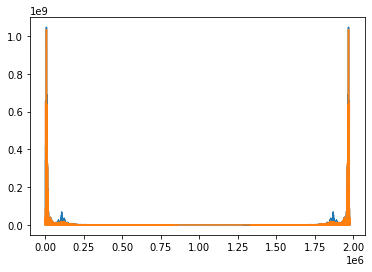

In [10]:
e = lms(0.00000000001, 100, bassLine1, talkingNoise1)
IPython.display.Audio(e, rate=samplerate, normalize=True) 
plt.plot(np.abs(np.fft.fft(bassLine1)))
plt.plot(np.abs(np.fft.fft(e)))

### Test on simulated data (sinusoid)
- `l` = length of the data
- `x` is the noise (made at random)
- `s` is the pure sinusoid
- `d` the received sound
- `K` the number of samples we buffer

We then compute our maximum value `mu` for $\mu$, based on the eigendecomposition of the noise. Finally we get our filtered output `e_sin`. 


In [77]:
l = samplerate*20
x = np.random.normal(0, 2, l)
n = np.arange(l)
s = np.sin(n * 2*np.pi * float(440)/samplerate )
d = s + x
K = 10

#get the maximum mu one can get
mu = max_mu(x, K, 100) 
e_sin = lms(mu/4000, K, d, x)
IPython.display.Audio(d, rate=samplerate, normalize=True) 

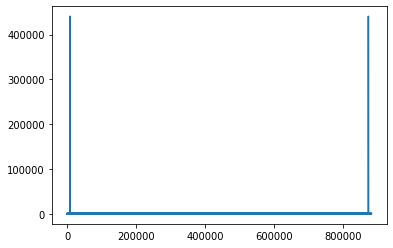

In [25]:
IPython.display.Audio(d, rate=samplerate, normalize=True) 

#### MSE analysis

Now we get the MSE for our `e_sin` compared to the original sinusoid `s`.

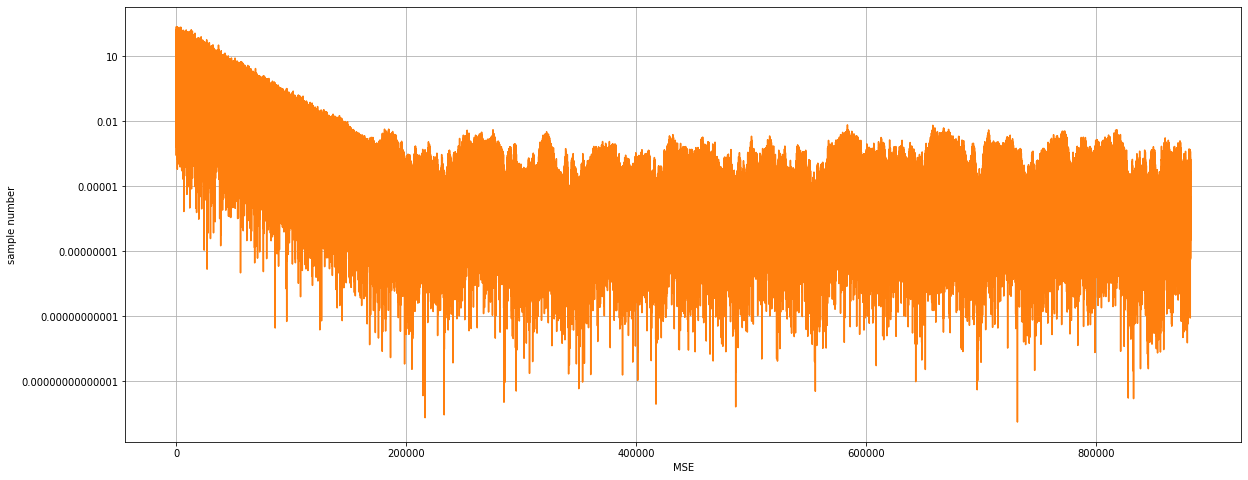

In [12]:
fig = plot_spectrum()
MSE_sin = MSE(e_sin, s)
fig.plot(MSE_sin)
plt.savefig('MSE_sinusoid_K10_sigma5')
plt.show()

We find the smallest sample after which all values are under the threshold using `find_smallest_samples`. The threshold is arbitrary. And then we compute the smallest sample for different values of $\mu$. 

In [66]:
#find smallest sample after which all values are under the threshold
def find_smallest_samples(mu_max, K, d, x, s, i,threshold):
    e_sin = lms(mu_max/i, K, d, x)
    MSE_sin = MSE(e_sin, s)
    return len(MSE_sin) - np.where(MSE_sin[::-1]>threshold)[0][0]

#get the list for different values of mu
def samples_thrs(mu_max, K, d, x, s,threshold=0.01, mu_div_range=range(10, 100000, 1000)):
    samples = np.zeros(len(mu_div_range))
    for count, i in enumerate(mu_div_range):
        samples[count] = find_smallest_samples(mu_max, K, d, x, s, i,threshold)
    return samples

Here is the plot that we get for the smallest sample after which all values are under thrsh as a function of $\mu$. We also find the best $\mu$ (the one giving the fastest convergence). 

In [14]:
def plot_spectrum_xlog(axis_bounds_x, xlabel, ylabel):
    fig, axs = plt.subplots(1, 1, figsize=(16, 8))
    axs.grid(True)
    axs.semilogx(10)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    plt.xlim(axis_bounds_x[0], axis_bounds_x[1])
    axs.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
    return axs

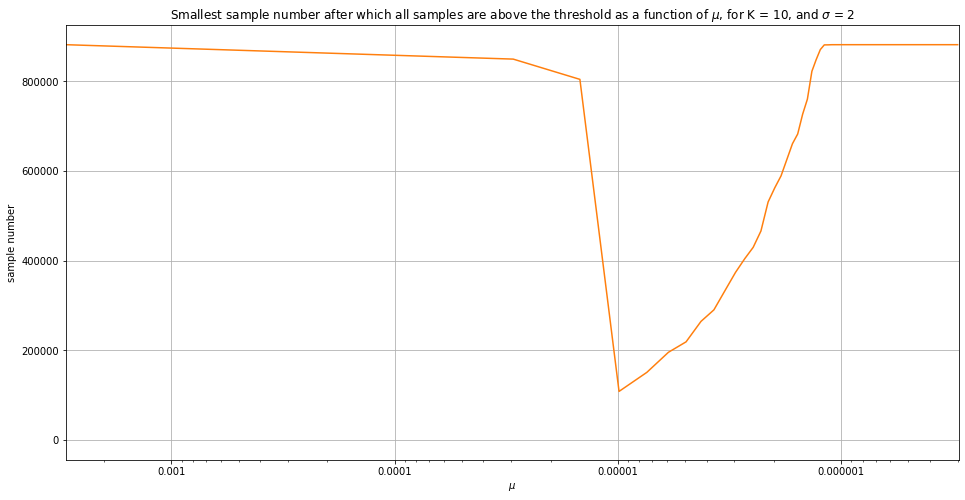

In [84]:
def draw_threshold_samples(K, sigma):
    n = np.arange(l)
    s = np.sin(n * 2*np.pi * float(440)/samplerate )
    noise = np.random.normal(0, sigma, l)
    d = s + noise
    
    mu = max_mu(noise, K, 100) 
    samples = samples_thrs(mu, K, d, noise, s)
    
    plot_spectrum_xlog([mu/10, mu/100000], '$\mu$', 'sample number')
    plt.plot(mu/range(10, 100000, 1000), samples)
    title = 'Smallest sample number after which all samples are above the threshold as a function of $\mu$, for K = '+ str(K)+', and $\sigma$ = '+str(sigma)
    plt.title(title)
    save_title = 'sample_graph_K'+ str(K) +'_sigma'+str(sigma)+'.png'
    plt.savefig(save_title)
    plt.show()
    return samples, mu
  
samples, mu = draw_threshold_samples(10, 2)

In [86]:
np.min(samples)

108492.0